In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
48,49,0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S


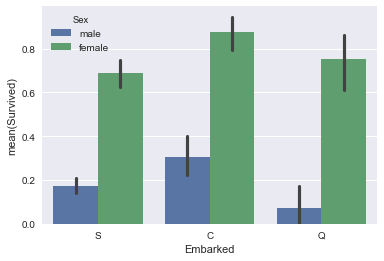

In [2]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

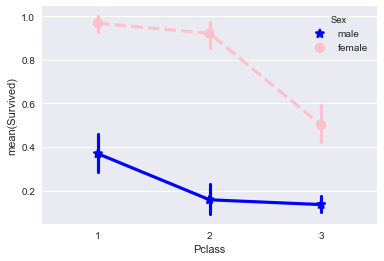

In [3]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [4]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,S,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,S,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,S,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,S,"Allen,",Mr.


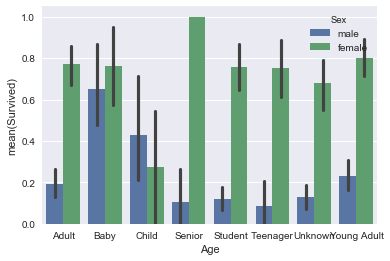

In [5]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

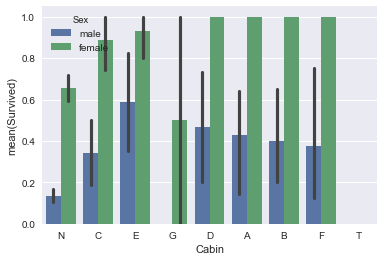

In [6]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

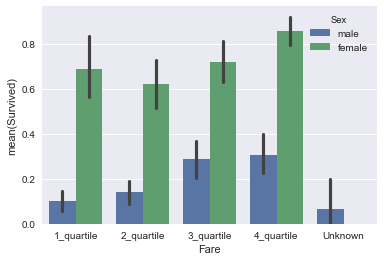

In [7]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

In [8]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')
data_train['Embarked'] = data_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
data_test['Embarked'] = data_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
data_train.sample(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
779,780,1,1,female,Adult,0,1,4_quartile,B,0,"Robert,",Mrs.
492,493,0,1,male,Adult,0,0,3_quartile,C,0,"Molson,",Mr.
751,752,1,3,male,Child,0,1,2_quartile,E,0,"Moor,",Master.


In [9]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.to_csv('Dtrain.csv')
data_test.to_csv('Dtest.csv')
data_train.sample(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
610,611,0,3,0,0,1,5,3,7,0,21,20
85,86,1,3,0,7,3,0,2,7,0,43,20
868,869,0,3,1,6,0,0,1,7,0,867,14


In [10]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=.2, random_state=23)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

# Run the grid search
classfier = GridSearchCV(RandomForestClassifier(), parameters, 'accuracy').fit(X_train, y_train).best_estimator_

# Fit the best algorithm and predict
predictions = classfier.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, predictions))

0.815642458101


In [12]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        predictions = classfier.fit(X_train, y_train).predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(classfier)

Fold 1 accuracy: 0.8111111111111111
Fold 2 accuracy: 0.8314606741573034
Fold 3 accuracy: 0.8089887640449438
Fold 4 accuracy: 0.8651685393258427
Fold 5 accuracy: 0.8539325842696629
Fold 6 accuracy: 0.8314606741573034
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.7865168539325843


D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.8539325842696629
Mean Accuracy: 0.8305493133583021


In [13]:
ids = data_test['PassengerId']
predictions = classfier.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
